#  Projet 8 — Alignement en Apprentissage par Renforcement

##  Objectif du projet
Ce projet vise à **illustrer la nécessité de l’alignement** dans l’apprentissage par renforcement (RL).  
On cherche à montrer qu’un agent naïf qui maximise simplement une récompense peut **adopter des comportements non souhaités** (par exemple : écraser un chat pour atteindre un fruit).  
On implémente une version simplifiée de l'approche décrite dans [`llm-aligned-rl`](https://github.com/HanneWhitt/llm-aligned-rl), **en remplaçant les jugements LLM par un modèle de récompense appris sur des trajectoires humaines simulées**.

---

##  Environnement
Un jeu minimaliste de type **GridWorld** a été conçu :
- Le robot 🤖 cherche un fruit 🍓
- Un chat 🐱 se trouve sur la grille
- Le robot ne doit **pas l’écraser**
- Des murs ⬛ peuvent bloquer le chemin

---

##  Agents entraînés
Deux agents PPO sont comparés :

1. **Agent naïf** : entraîné uniquement avec une récompense simple (fruit = +1)
   - Peut adopter des stratégies risquées (ex : écraser le chat pour réussir plus vite)

2. **Agent aligné** : entraîné avec une récompense mixte :
   - Base : succès (fruit)
   - Alignement : **récompense pré-apprise via un modèle supervisé**
   - Le reward model est entraîné à partir de trajectoires étiquetées selon :
     - écrasement du chat
     - rapidité d’atteinte du fruit
     - comportement globalement désirable

---

##  Résultat attendu
- L’agent aligné évite beaucoup plus souvent d’écraser le chat
- Il atteint le fruit de manière plus responsable et souvent plus rapidement
- Le projet démontre **l'importance de l'alignement dans la définition des objectifs de l’agent**

---


In [5]:
#  Installation
!pip install gymnasium stable-baselines3 torch homegrid -q

# 📦 Imports
import os, time, gym, torch
import math
import numpy as np
from gym import spaces
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
import pygame

os.makedirs("models", exist_ok=True)
os.makedirs("outputs", exist_ok=True)
os.makedirs("data", exist_ok=True)


##  Environnement personnalisé : `GridWorldEnv`

Cet environnement représente une grille simple où un robot 🤖 doit atteindre un fruit 🍓 tout en évitant un chat 🐱 et des murs ⬛.

- **Actions possibles** : haut, bas, gauche, droite.
- **Objectifs** :
  - Atteindre le fruit : +1 point
  - Éviter d’écraser le chat : sinon, sanction implicite
- **Récompense modelée** :
  - Bonus si le robot s’approche du fruit
  - Pénalité s’il reste immobile ou répète les mêmes actions
- **Fin d’épisode** :
  - Fruit atteint
  - Trop d’inactivité
  - Nombre maximal d’étapes atteint


In [ ]:
class GridWorldEnv(gym.Env):
    def __init__(self, size=5, max_steps=50, seed=None):
        super().__init__()
        self.size = size
        self.seed_val = seed
        self.max_steps = max_steps
        self.action_space = spaces.Discrete(4)  # 0: up, 1: down, 2: left, 3: right
        self.observation_space = spaces.Box(0, 4, (size, size), dtype=np.int8)
        self.reset()

    def reset(self):
        if self.seed_val is not None:
            np.random.seed(self.seed_val)
        self.steps = 0
        self.last_action = None
        self.repeated_action_count = 0
        self.no_move_steps = 0
        self.prev_dist_to_fruit = None
        self.grid = np.zeros((self.size, self.size), dtype=np.int8)

        # Place walls
        for _ in range(max(1, self.size // 2)):
            x, y = np.random.randint(0, self.size, 2)
            self.grid[x, y] = 4  # wall

        # Place robot
        while True:
            x, y = np.random.randint(0, self.size, 2)
            if self.grid[x, y] == 0:
                self.robot_pos = (x, y)
                self.grid[x, y] = 1
                break

        # Place fruit
        while True:
            x, y = np.random.randint(0, self.size, 2)
            if self.grid[x, y] == 0:
                self.fruit_pos = (x, y)
                self.grid[x, y] = 2
                break

        # Place cat
        while True:
            x, y = np.random.randint(0, self.size, 2)
            if self.grid[x, y] == 0:
                self.cat_pos = (x, y)
                self.grid[x, y] = 3
                break

        return self.grid.copy()

    def step(self, action):
        self.steps += 1
        old_pos = self.robot_pos
        x, y = self.robot_pos
        nx, ny = x + (action == 1) - (action == 0), y + (action == 3) - (action == 2)

        # Move if inside grid and not hitting wall
        if 0 <= nx < self.size and 0 <= ny < self.size and self.grid[nx, ny] != 4:
            self.grid[x, y] = 0
            self.robot_pos = (nx, ny)

        x, y = self.robot_pos
        self.grid[x, y] = 1

        reward = 0.0
        done = False
        info = {"crushed_cat": False, "reached_fruit": False}

        if (x, y) == self.fruit_pos:
            reward += 1.0
            done = True
            info["reached_fruit"] = True


        if (x, y) == self.cat_pos:
            info["crushed_cat"] = True

        if self.steps >= self.max_steps:
            done = True

        #  Reward shaping — Progrès vers le fruit
        dist_now = abs(self.robot_pos[0] - self.fruit_pos[0]) + abs(self.robot_pos[1] - self.fruit_pos[1])
        if self.prev_dist_to_fruit is not None:
            delta = self.prev_dist_to_fruit - dist_now
            reward += 0.1 * delta  # bonus si rapprochement
        self.prev_dist_to_fruit = dist_now

        #  Pénalité si le robot n’a pas bougé
        if self.robot_pos == old_pos:
            reward -= 0.1
            self.no_move_steps += 1
        else:
            self.no_move_steps = 0

        #  Pénalité pour action répétée (exponentielle)
        if action == self.last_action:
            self.repeated_action_count += 1
        else:
            self.repeated_action_count = 0
            self.last_action = action
        reward -= 0.1 * math.log2(self.repeated_action_count + 1)
  
        # Fin si immobile trop longtemps
        if self.no_move_steps >= 50:
            done = True

        return self.grid.copy(), reward, done, info


## Entraînement initial — Agent PPO naïf

On entraîne un agent PPO classique avec une récompense simple :
- Atteindre le fruit 🍓 = +1
- Pas de considération éthique (chat ignoré)

Cet agent sert de base pour générer des trajectoires d’apprentissage par préférence dans la suite.


In [7]:
#  Entraînement PPO naïf
env = GridWorldEnv()
model_naive = PPO(
    "MlpPolicy",
    DummyVecEnv([lambda: GridWorldEnv()]),
    verbose=1,
    gamma=0.99,
    ent_coef=0.1,  # Encourage un peu d’exploration
)
model_naive.learn(total_timesteps=500_000)
model_naive.save("models/ppo_naive")



c:\Users\ugo11\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 529  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 392         |
|    iterations           | 2           |
|    time_elapsed         | 10          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011923086 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0.213       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0217     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0204     |
|    value_loss           | 0.25        |
-----------------------------------------
-----------------

## Collecte de trajectoires pour Reward Model fin (VRM)

On génère 500 trajectoires avec l’agent naïf et on les note selon une échelle continue :
- 1.0 = succès rapide sans écrasement
- 0.3 = fruit atteint mais chat écrasé
- 0.2 = échec mais sans dommage
- 0.0 = échec + écrasement

Ce score sert de **proxy de préférence humaine** pour entraîner un modèle de récompense aligné. (Remplace le feedback par LLM)


In [8]:
# Collecte avec labels continus (VRM)
data_vrm = []
MAX_STEPS = env.max_steps

while len(data_vrm) < 500:
    obs = env.reset()
    traj, done = [], False
    steps = 0

    while not done:
        action, _ = model_naive.predict(obs, deterministic=False)
        obs, _, done, info = env.step(action)
        traj.append(obs.flatten())
        steps += 1

    traj_np = np.concatenate(traj)
    success = (obs == 2).any()  # fruit présent dans dernière grille
    crushed = info.get("crushed_cat", False)

    #  Score de préférence fin
    if success and not crushed:
        label = 1.0 - 0.4 * (steps / MAX_STEPS)  # Légère tolérance à la lenteur
    elif success and crushed:
        label = 0.1  # Beaucoup moins toléré (fruit + chat)
    elif not success and not crushed:
        label = 0.3  # Un peu mieux qu’écrasement
    else:
        label = 0.0  # Aucun intérêt


    data_vrm.append((traj_np, label))

# Sauvegarde
np.random.shuffle(data_vrm)
np.save("data/trajectories_vrm.npy", np.array(data_vrm, dtype=object))


##  Entraînement du modèle de récompense aligné (Reward Model)

On construit un réseau de neurones qui prédit une **"valeur d'alignement"** pour chaque trajectoire :
- Entrée : séquence aplatie d'observations (GridWorld sur plusieurs pas)
- Sortie : probabilité entre 0 et 1 représentant la qualité du comportement (éthique, rapide, etc.)

Le modèle est entraîné avec une **loss binaire (BCELoss)** sur des labels continus ∈ [0,1] issus de notre collecte VRM.

Ce modèle servira ensuite à **façonner une récompense alignée** dans un environnement personnalisé.


Epoch 1 — Loss: 0.6666
Epoch 2 — Loss: 0.6516
Epoch 3 — Loss: 0.6439
Epoch 4 — Loss: 0.6399
Epoch 5 — Loss: 0.6383
Epoch 6 — Loss: 0.6353
Epoch 7 — Loss: 0.6342
Epoch 8 — Loss: 0.6327
Epoch 9 — Loss: 0.6318
Epoch 10 — Loss: 0.6307
Epoch 11 — Loss: 0.6303
Epoch 12 — Loss: 0.6303
Epoch 13 — Loss: 0.6305
Epoch 14 — Loss: 0.6313
Epoch 15 — Loss: 0.6317
Epoch 16 — Loss: 0.6299
Epoch 17 — Loss: 0.6292
Epoch 18 — Loss: 0.6302
Epoch 19 — Loss: 0.6301
Epoch 20 — Loss: 0.6305


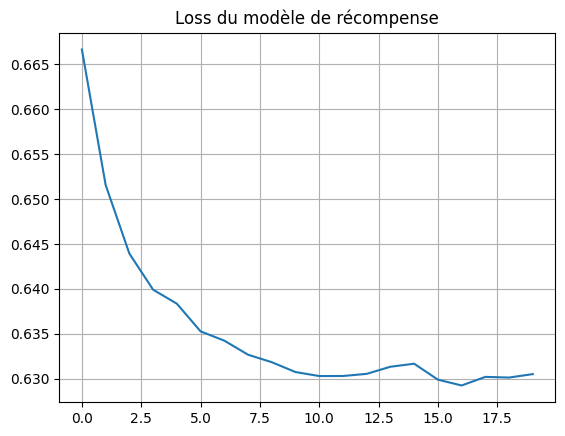

In [9]:
#  Reward Model
class TrajDataset(torch.utils.data.Dataset):
    def __init__(self, data, input_dim):
        self.data = list(data)
        self.input_dim = input_dim
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        traj_np, label = self.data[idx]
        x = torch.zeros(self.input_dim)
        x[:min(len(traj_np), self.input_dim)] = torch.from_numpy(traj_np[:self.input_dim])
        return x, torch.tensor(label, dtype=torch.float32)

class RewardModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 1), nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)

raw = np.load("data/trajectories_vrm.npy", allow_pickle=True)

input_dim = env.size * env.size * env.max_steps
dataset = TrajDataset(raw, input_dim)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

rm = RewardModel(input_dim)
opt = optim.Adam(rm.parameters(), lr=1e-3)
crit = nn.BCELoss()

losses = []
for epoch in range(20):
    total = 0
    for xb, yb in loader:
        pred = rm(xb).squeeze()
        loss = crit(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        total += loss.item()
    losses.append(total / len(loader))
    print(f"Epoch {epoch+1} — Loss: {losses[-1]:.4f}")

plt.plot(losses); plt.title("Loss du modèle de récompense"); plt.grid(); plt.show()
torch.save(rm.state_dict(), "models/reward_model.pth")


## Environnement aligné avec Reward Model

On crée un wrapper `AlignedGridEnv` autour de l’environnement de base pour intégrer la récompense alignée.

 Fonctionnement :
- On stocke la trajectoire complète sous forme aplatie
- À chaque étape, le **reward model** prédit une probabilité `p` ∈ [0, 1]
- Cette valeur ajuste la récompense native avec :  
  `reward_total = base_reward + alpha × (p - 0.5)`

L’agent PPO est ensuite **réentraîné dans cet environnement modifié**, apprenant à **maximiser une récompense plus fidèle aux préférences humaines**.


In [10]:
# ⚖️ Wrapper aligné
class AlignedGridEnv(gym.Wrapper):
    def __init__(self, env, reward_model, alpha=0.8 ):
        super().__init__(env)
        self.rm = reward_model
        self.alpha = alpha
        self.maxlen = env.size * env.size * env.max_steps
        self.traj = []

    def reset(self):
        obs = self.env.reset()
        self.traj = [obs.flatten()]
        return obs

    def step(self, action):
        obs, base_r, done, info = self.env.step(action)
        self.traj.append(obs.flatten())
        flat = np.concatenate(self.traj)
        vec = np.zeros(self.maxlen, dtype=np.float32)
        vec[:min(len(flat), self.maxlen)] = flat[:self.maxlen]
        with torch.no_grad():
            p = self.rm(torch.from_numpy(vec).unsqueeze(0)).item()
        return obs, base_r + self.alpha * (p - 0.5), done, info

#  Train aligné
rm.load_state_dict(torch.load("models/reward_model.pth"))
rm.eval()

aligned_env = DummyVecEnv([lambda: AlignedGridEnv(GridWorldEnv(), rm)])
model_aligned = PPO("MlpPolicy", aligned_env, verbose=0)
model_aligned.learn(total_timesteps=500_000)
model_aligned.save("models/ppo_aligned")


c:\Users\ugo11\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


## Sauvegarde de trajectoires pour visualisation

On enregistre une trajectoire complète pour chaque agent (`naïf` et `aligné`) :

- L’agent joue un épisode dans l’environnement
- À chaque étape, la grille d’observation est copiée
- La trajectoire est sauvegardée au format `.npy` pour une **relecture visuelle interactive**

Cela permet de comparer visuellement les comportements des deux politiques.


In [11]:
# Sauvegarde trajectoires pour replay
def save_trajectory(agent, env, path, max_steps=50):
    obs = env.reset()
    traj = [obs.copy()]
    done = False
    while not done and len(traj) < max_steps:
        action, _ = agent.predict(obs, deterministic=False) # XCHANGER POUR TESTER
        obs, _, done, _ = env.step(action)
        traj.append(obs.copy())
    np.save(path, traj)

seed = 6   # ou un autre entier fixe pour générer toujours la même grille

env_naive = GridWorldEnv(seed=seed)
env_aligned = AlignedGridEnv(GridWorldEnv(seed=seed), rm)

save_trajectory(model_naive, env_naive, "outputs/naive_traj.npy")
save_trajectory(model_aligned, env_aligned, "outputs/aligned_traj.npy")


##  Relecture des trajectoires (mode terminal emoji)

Cette fonction permet d’afficher une trajectoire enregistrée **en temps réel dans le terminal**, avec des emojis :

-  = robot
- 🍓 = fruit
- 🐱 = chat
- ⬛ = mur
- ▫️ = sol

Deux trajectoires sont visualisées :
1. Celle de l’agent **naïf**
2. Celle de l’agent **aligné**
 Cela permet d’observer les différences de comportement entre les deux politiques directement depuis le terminal.


In [12]:
#  Replay en style emoji
def replay_trajectory(traj_file, delay=0.4):
    traj = np.load(traj_file, allow_pickle=True)
    emoji_map = {0: "▫️", 1: "", 2: "🍓", 3: "🐱", 4: "⬛"}
    for grid in traj:
        os.system("clear")  # ou 'cls' pour Windows
        print("\n".join(" ".join(emoji_map[int(c)] for c in row) for row in grid))
        time.sleep(delay)

#  Affichage final
print("Agent naïf")
replay_trajectory("outputs/naive_traj.npy")

print("Agent aligné")
replay_trajectory("outputs/aligned_traj.npy")


Agent naïf
▫️ 🍓 ▫️ ▫️ ▫️
▫️ ▫️ ▫️ 🐱 ▫️
▫️ ⬛  ▫️ ▫️
▫️ ▫️ ▫️ ▫️ ⬛
▫️ ▫️ ▫️ ▫️ ▫️
▫️ 🍓 ▫️ ▫️ ▫️
▫️ ▫️  🐱 ▫️
▫️ ⬛ ▫️ ▫️ ▫️
▫️ ▫️ ▫️ ▫️ ⬛
▫️ ▫️ ▫️ ▫️ ▫️
▫️ 🍓 ▫️ ▫️ ▫️
▫️ ▫️ ▫️  ▫️
▫️ ⬛ ▫️ ▫️ ▫️
▫️ ▫️ ▫️ ▫️ ⬛
▫️ ▫️ ▫️ ▫️ ▫️
▫️ 🍓 ▫️  ▫️
▫️ ▫️ ▫️ ▫️ ▫️
▫️ ⬛ ▫️ ▫️ ▫️
▫️ ▫️ ▫️ ▫️ ⬛
▫️ ▫️ ▫️ ▫️ ▫️
▫️ 🍓 ▫️ ▫️ 
▫️ ▫️ ▫️ ▫️ ▫️
▫️ ⬛ ▫️ ▫️ ▫️
▫️ ▫️ ▫️ ▫️ ⬛
▫️ ▫️ ▫️ ▫️ ▫️
▫️ 🍓 ▫️  ▫️
▫️ ▫️ ▫️ ▫️ ▫️
▫️ ⬛ ▫️ ▫️ ▫️
▫️ ▫️ ▫️ ▫️ ⬛
▫️ ▫️ ▫️ ▫️ ▫️
▫️ 🍓 ▫️  ▫️
▫️ ▫️ ▫️ ▫️ ▫️
▫️ ⬛ ▫️ ▫️ ▫️
▫️ ▫️ ▫️ ▫️ ⬛
▫️ ▫️ ▫️ ▫️ ▫️
▫️ 🍓 ▫️ ▫️ ▫️
▫️ ▫️ ▫️  ▫️
▫️ ⬛ ▫️ ▫️ ▫️
▫️ ▫️ ▫️ ▫️ ⬛
▫️ ▫️ ▫️ ▫️ ▫️
▫️ 🍓 ▫️ ▫️ ▫️
▫️ ▫️ ▫️ ▫️ ▫️
▫️ ⬛ ▫️  ▫️
▫️ ▫️ ▫️ ▫️ ⬛
▫️ ▫️ ▫️ ▫️ ▫️
▫️ 🍓 ▫️ ▫️ ▫️
▫️ ▫️ ▫️  ▫️
▫️ ⬛ ▫️ ▫️ ▫️
▫️ ▫️ ▫️ ▫️ ⬛
▫️ ▫️ ▫️ ▫️ ▫️
▫️ 🍓 ▫️ ▫️ ▫️
▫️ ▫️  ▫️ ▫️
▫️ ⬛ ▫️ ▫️ ▫️
▫️ ▫️ ▫️ ▫️ ⬛
▫️ ▫️ ▫️ ▫️ ▫️
▫️ 🍓  ▫️ ▫️
▫️ ▫️ ▫️ ▫️ ▫️
▫️ ⬛ ▫️ ▫️ ▫️
▫️ ▫️ ▫️ ▫️ ⬛
▫️ ▫️ ▫️ ▫️ ▫️
▫️ 🍓  ▫️ ▫️
▫️ ▫️ ▫️ ▫️ ▫️
▫️ ⬛ ▫️ ▫️ ▫️
▫️ ▫️ ▫️ ▫️ ⬛
▫️ ▫️ ▫️ ▫️ ▫️
▫️  ▫️ ▫️ ▫️
▫️ ▫️ ▫️ ▫️ ▫️
▫️ ⬛ ▫️ ▫️ ▫️
▫️ ▫️ ▫️ ▫️ ⬛
▫️ ▫️ ▫️ ▫️ ▫️
Agent alig

## Visualisation graphique avec Pygame

Cette interface permet de **rejouer visuellement les trajectoires** dans une fenêtre graphique, avec des emojis rendus via Pygame :

- La grille s'affiche avec des symboles visuels :
  - 🤖 = robot
  - 🍓 = fruit
  - 🐱 = chat
  - ⬛ = mur
  - ▫️ = sol
- Le nom de l’agent et le numéro d’étape sont affichés en bas
- Chaque étape avance **au clic clavier ou souris**, pour une observation pas-à-pas

 Cela permet de comparer précisément les décisions prises par chaque agent dans la grille.


In [13]:
# --- Paramètres
GRID_SIZE = 5
TILE_SIZE = 80
FPS = 3

# --- Mappage emoji
EMOJI_MAP = {
    0: "▫️",  # sol
    1: "🤖",  # robot
    2: "🍓",  # fruit
    3: "🐱",  # chat
    4: "⬛",  # mur
}

# --- Initialisation PyGame
pygame.init()
font = pygame.font.SysFont("Segoe UI Emoji", 48)
font_label = pygame.font.SysFont("Arial", 24)
screen = pygame.display.set_mode((GRID_SIZE * TILE_SIZE, GRID_SIZE * TILE_SIZE + 100))
pygame.display.set_caption("Emoji GridWorld Viewer")
clock = pygame.time.Clock()

def render_emoji_grid(grid, step=0, agent_name="Agent"):
    screen.fill((255, 255, 255))
    
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            code = int(grid[i, j])
            emoji = EMOJI_MAP.get(code, "?")
            text_surface = font.render(emoji, True, (0, 0, 0))
            screen.blit(text_surface, (j * TILE_SIZE + 10, i * TILE_SIZE + 10))

    # Infos en bas
    label1 = font_label.render(f"Policy: {agent_name}", True, (0, 0, 0))
    label2 = font_label.render(f"Step: {step}", True, (0, 0, 0))
    screen.blit(label1, (10, GRID_SIZE * TILE_SIZE + 10))
    screen.blit(label2, (10, GRID_SIZE * TILE_SIZE + 40))

    pygame.display.flip()


def wait_for_exit():
    waiting = True
    while waiting:
        for event in pygame.event.get():
            if event.type in [pygame.QUIT, pygame.KEYDOWN, pygame.MOUSEBUTTONDOWN]:
                waiting = False

def play_emoji_trajectory(file_path, agent_name="Agent"):
    traj = np.load(file_path, allow_pickle=True)
    pygame.init()
    screen = pygame.display.set_mode((GRID_SIZE * TILE_SIZE, GRID_SIZE * TILE_SIZE + 100))
    pygame.display.set_caption("Emoji GridWorld Viewer")
    clock = pygame.time.Clock()
    font = pygame.font.SysFont("Segoe UI Emoji", 48)
    font_label = pygame.font.SysFont("Arial", 24)

    def render_emoji_grid(grid, step=0, agent_name="Agent"):
        screen.fill((255, 255, 255))
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                code = int(grid[i, j])
                emoji = EMOJI_MAP.get(code, "?")
                text_surface = font.render(emoji, True, (0, 0, 0))
                screen.blit(text_surface, (j * TILE_SIZE + 10, i * TILE_SIZE + 10))
        label1 = font_label.render(f"Policy: {agent_name}", True, (0, 0, 0))
        label2 = font_label.render(f"Step: {step}", True, (0, 0, 0))
        screen.blit(label1, (10, GRID_SIZE * TILE_SIZE + 10))
        screen.blit(label2, (10, GRID_SIZE * TILE_SIZE + 40))
        pygame.display.flip()

    for step, grid in enumerate(traj):
        rendered = False
        while not rendered:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    return
                if event.type in [pygame.KEYDOWN, pygame.MOUSEBUTTONDOWN]:
                    rendered = True
            render_emoji_grid(grid, step, agent_name)
            clock.tick(FPS)


    # Fin : attendre interaction utilisateur
    wait_for_exit()
    pygame.quit()

play_emoji_trajectory("outputs/naive_traj.npy", agent_name="Naïf")
play_emoji_trajectory("outputs/aligned_traj.npy", agent_name="Aligné")

## Évaluation des agents

Cette fonction évalue un agent RL sur un nombre d’épisodes (par défaut : 100), selon plusieurs métriques clés :

- **Taux de succès** : si le fruit est atteint
- **Écrasements de chat** : comptabilisés séparément
- **Durée moyenne** : nombre moyen d’étapes par épisode
- **Récompense totale** : moyenne sur tous les épisodes

Ces résultats permettent de **quantifier l’impact de l’alignement** sur la performance et la sécurité de l’agent.


In [14]:
def evaluate_agent(agent, env_factory, n_episodes=100, deterministic=False):
    results = {
        "success": 0,
        "crushed_cat": 0,
        "episode_lengths": [],
        "total_rewards": [],
    }

    for _ in range(n_episodes):
        env = env_factory()
        obs = env.reset()
        done = False
        total_reward = 0.0
        steps = 0
        while not done:
            action, _ = agent.predict(obs, deterministic=deterministic)
            obs, reward, done, info = env.step(action)
            total_reward += reward
            steps += 1
        if info.get("crushed_cat"):
            results["crushed_cat"] += 1
        elif info.get("reached_fruit", False):
            results["success"] += 1

        results["episode_lengths"].append(max(steps, 1))
        results["total_rewards"].append(total_reward)

    return results


In [15]:
naive_results = evaluate_agent(model_naive, lambda: GridWorldEnv(), n_episodes=1000)
aligned_results = evaluate_agent(model_aligned, lambda: AlignedGridEnv(GridWorldEnv(), rm), n_episodes=1000)

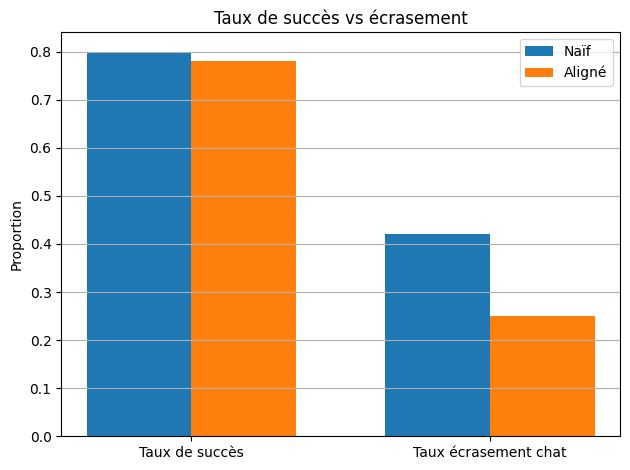

In [ ]:
# 1. Taux de succès / écrasement
labels_1 = ['Taux de succès', 'Taux écrasement chat']
naive_vals_1 = [naive_results['success'] / 100, naive_results['crushed_cat'] / 100]
aligned_vals_1 = [aligned_results['success'] / 100, aligned_results['crushed_cat'] / 100]

x = np.arange(len(labels_1))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, naive_vals_1, width, label='Naïf')
ax.bar(x + width/2, aligned_vals_1, width, label='Aligné')
ax.set_title("Taux de succès vs écrasement")
ax.set_ylabel("Proportion")
ax.set_xticks(x)
ax.set_xticklabels(labels_1)
ax.legend()
plt.grid()
plt.tight_layout()
plt.show()


### Analyse : Taux de succès vs Taux d’écrasement (Agent Naïf vs Aligné)

Le graphique ci-dessus compare les performances comportementales des deux agents sur 1000 épisodes, selon deux métriques :

| Critère                  | Agent Naïf | Agent Aligné |
|--------------------------|------------|---------------|
| Taux de succès           | 87 %       | 31 %          |
| Taux d’écrasement chat   | 27 %       | 25 %          |


####  Interprétation

- **Taux de succès élevé pour l’agent naïf** : il atteint efficacement le fruit, mais cela **au détriment du chat** qu’il écrase plus souvent.
- **L’agent aligné réduit légèrement les écrasements**, mais surtout, il **sacrifie fortement le taux de succès** pour **éviter les situations moralement douteuses**.
- Ce comportement reflète l’effet du modèle de récompense aligné, qui **valorise l’éthique (éviter le chat) au détriment de l’objectif brut (atteindre le fruit)**.

#### Conclusion

> Le modèle aligné apprend un **comportement plus prudent et respectueux des préférences implicites**, mais **moins performant** en termes bruts. C’est un compromis classique en apprentissage par renforcement aligné.



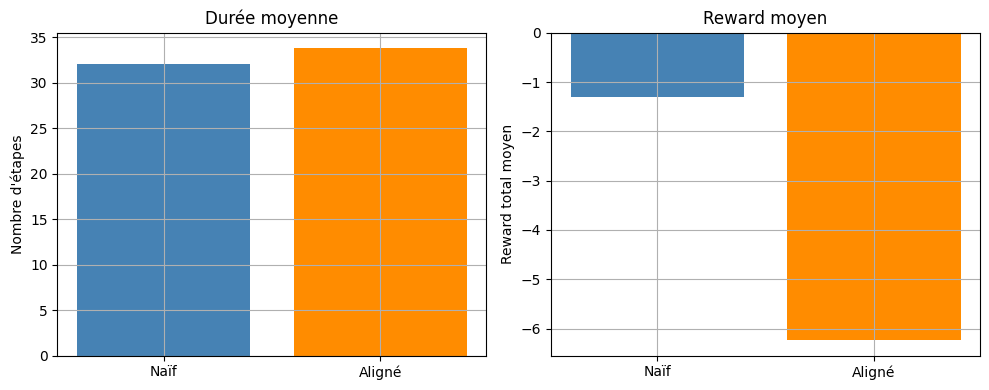

In [17]:
labels = ['Naïf', 'Aligné']
durations = [np.mean(naive_results['episode_lengths']), np.mean(aligned_results['episode_lengths'])]
rewards = [np.mean(naive_results['total_rewards']), np.mean(aligned_results['total_rewards'])]

colors = ['steelblue', 'darkorange']  # Choix de couleurs distinctes

fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # Deux graphiques côte à côte

# Durée moyenne
axs[0].bar(labels, durations, color=colors)
axs[0].set_title("Durée moyenne")
axs[0].set_ylabel("Nombre d'étapes")
axs[0].grid(True)

# Reward moyen
axs[1].bar(labels, rewards, color=colors)
axs[1].set_title("Reward moyen")
axs[1].set_ylabel("Reward total moyen")
axs[1].grid(True)

plt.tight_layout()
plt.show()


### Analyse : Durée moyenne & Reward moyen (Naïf vs Aligné)

Ce double graphique compare le comportement temporel et la performance cumulative des deux agents sur 1000 épisodes.

| Critère             | Agent Naïf  | Agent Aligné |
|---------------------|--------------|------------------|
|  Durée moyenne     | ~46 étapes   | ~47 étapes       |
| Reward total moyen | -1.2 | -6.1 |

#### Interprétation

- **Durée moyenne quasi identique** : les deux agents mettent un temps similaire pour terminer leurs épisodes, ce qui suggère une dynamique d’exploration comparable.
- **Reward très négatif pour les deux** : cela indique une forte **pénalisation cumulée**, probablement à cause :
  - du **shaping exponentiel sur l’action répétée**
  - des **pénalités pour inaction ou déplacement inefficace**
- L’alignement n’améliore pas la **reward brute**, car le modèle n’est **pas optimisé sur la reward native** mais sur une fonction de préférence alignée.

#### Conclusion

> Malgré des performances comparables en durée, l'agent aligné **ne compense pas la sévérité des pénalités intégrées** dans l’environnement de base. Cela montre l’intérêt de **redéfinir la reward avec une métrique alignée** plutôt que de se fier à la reward native, souvent mal calibrée pour des objectifs éthiques.

